In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset

**Data Prep**

In [2]:
# Download the dataset to the data directory
path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")

In [3]:
df = pd.read_csv(os.path.join(path, "Training_Essay_Data.csv"))
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [4]:
df = df.rename(columns={'generated': 'label'})
print(f"Dataset shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
print(f"Label distribution: {df['label'].value_counts()}")

Dataset shape: (29145, 2)
Column names: ['text', 'label']
Label distribution: label
0    17508
1    11637
Name: count, dtype: int64


In [5]:
# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

In [6]:
print(f"Train set: {train_df.shape[0]} samples")
print(f"Validation set: {val_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")

Train set: 20401 samples
Validation set: 4372 samples
Test set: 4372 samples


In [7]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

**Model Training**

In [8]:
from transformers import GPT2Tokenizer

# Load the GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set padding token to be the same as the eos_token
tokenizer.pad_token = tokenizer.eos_token

from transformers import GPT2ForSequenceClassification, Trainer, TrainingArguments

# Load the pre-trained GPT2 model with classification head
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = model.config.eos_token_id

# Ensure the pad_token is set correctly
print(f"Padding token is set to: {tokenizer.pad_token}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Padding token is set to: <|endoftext|>


In [9]:
def preprocess_function(examples):
    # Tokenizing the input texts
    tokenized_inputs = tokenizer(
        examples['text'],            # Input text
        truncation=True,             # Truncate to the max length
        padding=True,                # Apply padding (ensures all sequences in batch are the same length)
        max_length=128               # Max length for the sequence
    )
    
    # Return the tokenized input and labels
    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],  # Attention mask to indicate padding tokens
        'labels': examples['label']  # Labels (AI generated or human generated)
    }

In [10]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/20401 [00:00<?, ? examples/s]

Map:   0%|          | 0/4372 [00:00<?, ? examples/s]

Map:   0%|          | 0/4372 [00:00<?, ? examples/s]

In [11]:

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    evaluation_strategy="epoch",     # Evaluate after every epoch
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    num_train_epochs=3,              # Number of training epochs
    weight_decay=0.01,               # Weight decay strength
    save_steps=10_000,               # Save model every 10k steps
    logging_dir='./logs',            # Directory for storing logs
)

# Setup Trainer
trainer = Trainer(
    model=model,                     # Model to train
    args=training_args,              # Training arguments
    train_dataset=train_dataset,     # Training dataset
    eval_dataset=val_dataset,        # Validation dataset
    tokenizer=tokenizer,             # Tokenizer for padding/truncation
)


/home/yuk7du/.local/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/yuk7du/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/tmp/ipykernel_948590/2713081294.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.040900,0.292858
2,0.016700,0.341423
3,0.000100,0.252915


TrainOutput(global_step=7653, training_loss=0.03984930455412311, metrics={'train_runtime': 9388.611, 'train_samples_per_second': 6.519, 'train_steps_per_second': 0.815, 'total_flos': 3998036256620544.0, 'train_loss': 0.03984930455412311, 'epoch': 3.0})

**Eval**

In [13]:
# Save the fine-tuned model and tokenizer
save_dir = "./fine_tuned_gpt2"
model_name = "gpt2-ai-detector"

os.makedirs(save_dir, exist_ok=True)

model.save_pretrained(f"{save_dir}/{model_name}")
tokenizer.save_pretrained(f"{save_dir}/{model_name}")

training_logs = pd.DataFrame(trainer.state.log_history)
training_logs.to_csv(f"{save_dir}/{model_name}_training_log.csv", sep='\t')

In [16]:
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [17]:
metric = evaluate.combine(["accuracy", "precision", "recall", "f1"])

# Evaluate on test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Get probabilities for ROC curve (probability of class 1 - AI text)
probs = predictions.predictions[:, 1]

# Calculate metrics
metrics_result = metric.compute(predictions=preds, references=labels)

In [18]:
print("\nEvaluation Results:")
for metric_name, value in metrics_result.items():
    print(f"{metric_name}: {value:.4f}")


Evaluation Results:
accuracy: 0.9723
precision: 0.9366
recall: 0.9983
f1: 0.9664


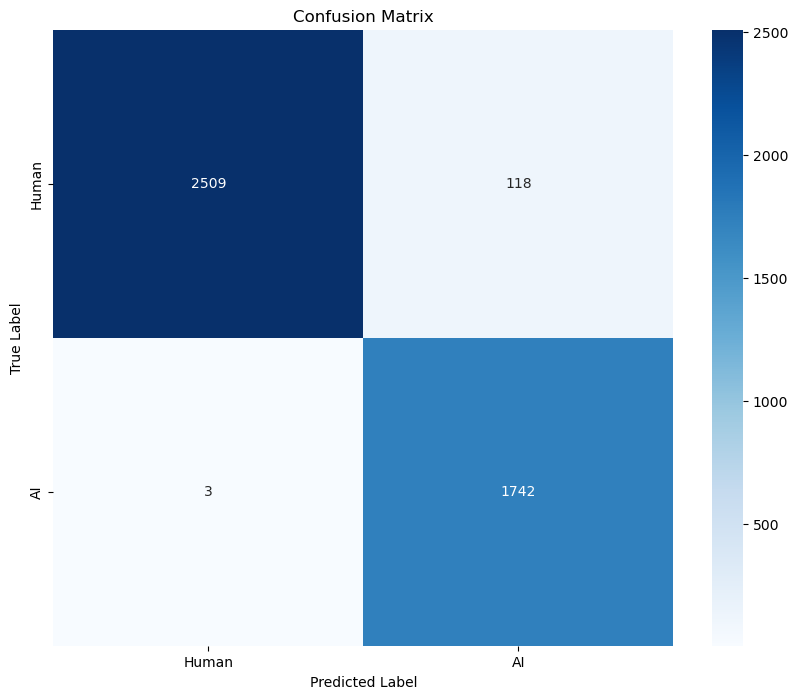

In [19]:
# Generate and display confusion matrix
class_names = ["Human", "AI"]
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig(f"{save_dir}/{model_name}_confusion_matrix.png")
plt.show()

In [20]:
correct_human = cm[0][0]
incorrect_human = cm[0][1]
correct_ai = cm[1][1]
incorrect_ai = cm[1][0]

results_table = pd.DataFrame({
    "Class": ["Human", "AI"],
    "Correct Predictions": [correct_human, correct_ai],
    "Misclassifications": [incorrect_human, incorrect_ai]
})

print("\nClassification Results:")
display(results_table)


Classification Results:


,Class,Correct Predictions,Misclassifications
0,Human,2509,118
1,AI,1742,3
